# **ENDG 511 Lab 2 Assignment: Model Pruning and Quantization**

This colab notebook provides code and a framework for ***Lab 3***. You can work out your solutions here.


## Goals

In this lab, you will be introduced to different model optimization methods using TensorFlow and Keras, and you will learn how to use them to create efficient deep learning models. The goals of this lab are:

- Understand the basics of pruning and quantization.
- Apply pruning and quantization to an MNIST model.
- Understand and use TFLite.
- Evaluate models in terms of accuracy, size and inference time.
- Understand how different pruning and quantization parameters can impact accuracy, size and inference time.
- Apply collaborative optimization by combining pruning and quantization.

## Layout
This lab is split into **three** parts.
- **Part 1**: Apply pruning to an MNIST model and evaluate the pruned model.
- **Part 2**: Apply post-training quantization and evaluate the quantized model.
- **Part 3**: Combine pruning and post-training quantization and evaluate the final model.

## How to submit the Assignment

- You are required to sumbmit the completed python notebook and a **pdf version** of it in a Dropbox folder on D2L.
- This is an individual assignment, and all the assignements must be submitted individually.
- This assignment can be completed directly on Google Colab, but you are free to choose any other computing resource.
-  Lab sessions will be held to go over the main concepts and help you with the assignment.


# **Part 1**: Pruning

This part of the lab demonstrates applying pruning to a neural network to reduce size and inference while maintaining a similar accuracy to the original neural network. At a high level, the steps required to prune and evaluate a model are as follows:

- Build and train the dense baseline
- Prune model
- Fine-tune pruned model
- Evaluate the model

There are different types of pruning techniques, the technique demonstrated in this lab is magnitude-based weight pruning (also referred to as unstructured pruning). Magnitude-based weight pruning gradually zeroes out model weights based on their importance during the training process to achieve model sparsity. Sparse models are easier to compress, and we can skip the zeroes during inference for latency improvements. The image below can help you visualize pruning:

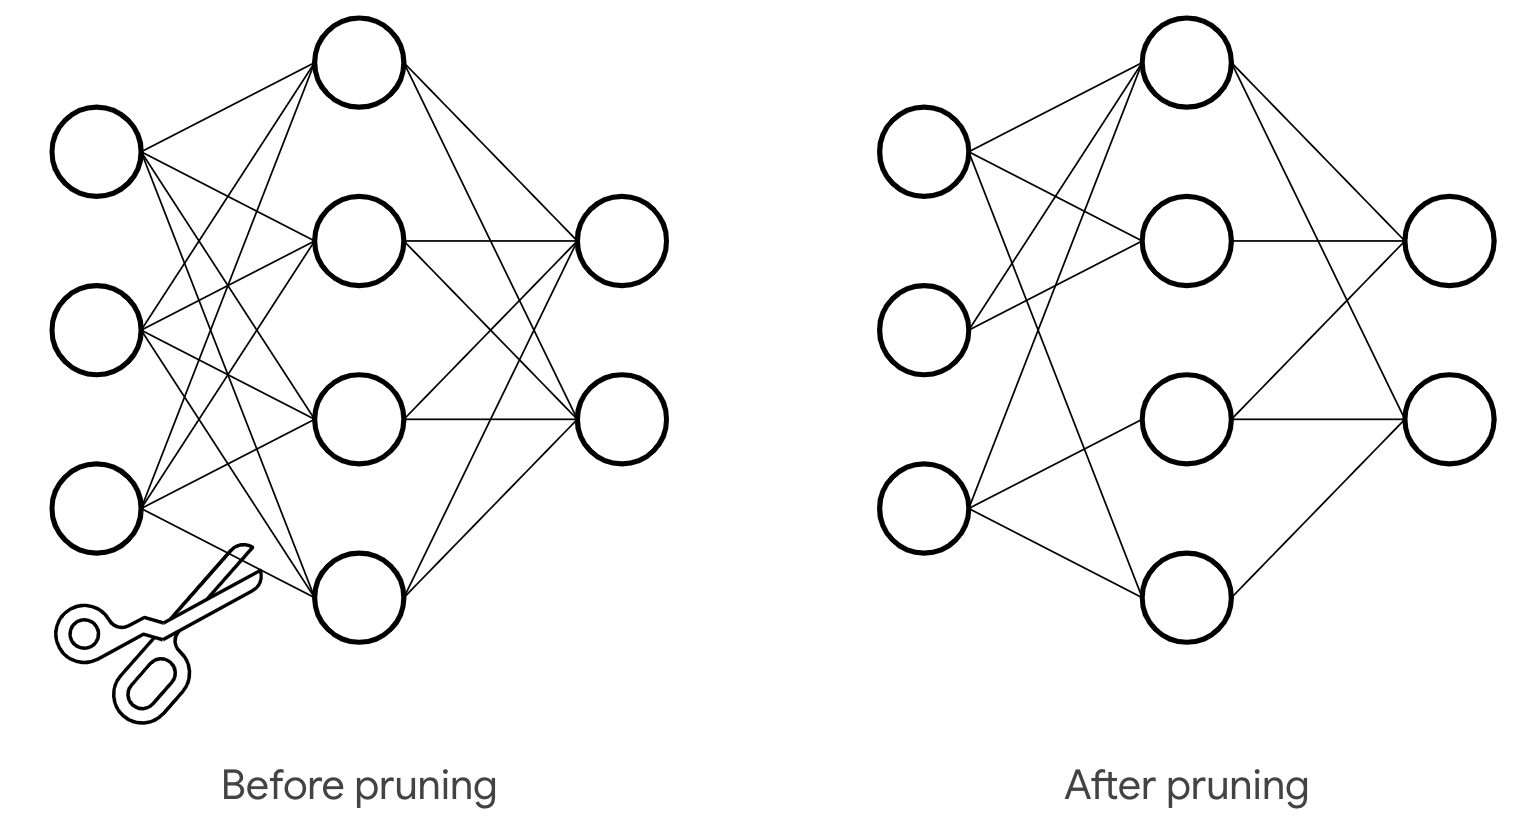

### Import and install all required modules

In [1]:
!pip install -q tensorflow-model-optimization


import tempfile
import os
import time
import torch

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_model_optimization as tfmot

2024-02-03 06:07:30.116186: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-03 06:07:30.116253: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-03 06:07:30.387722: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-03 06:07:30.749741: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-03 06:07:34.221689: W tensorflow/compiler/tf2

### Build and Train a neural network for MNIST without pruning

Similar to the examples presented in Lab1 we will build and train a neural network for the MNIST dataset without any model optimization. This will be our base model for the remainder of this lab. We also save the model before training.


In [2]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture.
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

# Save untrained model
model.save('untrained_base_model.h5')

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_split=0.1,
)

Epoch 1/5


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
2024-02-03 06:07:40.610891: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


1688/1688 [==============================] - 5s 2ms/step - loss: 0.3094 - accuracy: 0.9100 - val_loss: 0.1307 - val_accuracy: 0.9633
Epoch 2/5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.1502 - accuracy: 0.9548 - val_loss: 0.0954 - val_accuracy: 0.9728
Epoch 3/5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.1121 - accuracy: 0.9659 - val_loss: 0.0795 - val_accuracy: 0.9765
Epoch 4/5
1688/1688 [==============================] - 3s 2ms/step - loss: 0.0929 - accuracy: 0.9714 - val_loss: 0.0757 - val_accuracy: 0.9787
Epoch 5/5
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0776 - accuracy: 0.9754 - val_loss: 0.0675 - val_accuracy: 0.9812


Let's display the architecture of our model:

In [3]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Save model
Let us save the trained model so that we can evaluate at a later stage.

In [4]:
# Save your trained model
model.save('trained_base_model.h5')

### Prune the dense model
We will create a pruned model from our original model. We will force the model to have 50% sparsity (50% of the weights are zeroed out). Finally we recompile our new pruned model.

Note: ConstantSparsity performs "one-shot" magnitude based pruning of all the layers. There are more advanced techniques but this is the simplest one. The total number of parameters increases because tensorflow adds a "pruning wrapper" to all parameters, this gets stripped at a later stage.

In [5]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
## Print weights before and after

# Define model for pruning. The 0.5 is the target sparsity (50%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
}

pruned_model = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
pruned_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pruned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

### Fine-tune pruned model
Next, we have to fine-tune our pruned model by retraining for a suitable number of epochs.
Note: tfmot.sparsity.keras.UpdatePruningStep is required as a callback during training.

In [6]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_model.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                  callbacks=callbacks)

Epoch 1/2


2024-02-03 06:08:02.612182: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


1688/1688 [==============================] - 6s 2ms/step - loss: 0.0709 - accuracy: 0.9779 - val_loss: 0.0628 - val_accuracy: 0.9813
Epoch 2/2
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0583 - accuracy: 0.9812 - val_loss: 0.0624 - val_accuracy: 0.9822


### Apply strip pruning

strip_pruning is necessary since it removes every tf.Variable that pruning only needs during training, which would otherwise add to the final model size. It strips the pruning wrapper, It is also needed when converting to a TFLite model.

In [7]:
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
stripped_pruned_model.save('stripped_pruned_model.h5')

### Confirm that pruning was correctly applied

In [8]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )
print_model_weights_sparsity(stripped_pruned_model)

dense/kernel:0: 50.00% sparsity  (50176/100352)
dense_1/kernel:0: 50.00% sparsity  (640/1280)


### Evaluate the model
Finally, we compare the pruned model to the base model. We can see that the accuracy and inference time is comparable, however, the pruned model is much smaller in size.

Note: Pruning is capable of improving inference time significantly, however, additional libraries and modifications are needed to see inference improvements as a result of pruning (Pruning inference improvements is very hardware specific!). If you are curious you can read this paper which explains how sparse models can be used to accelerate inference (https://arxiv.org/pdf/1911.09723.pdf)

In [9]:
# Evaluate prediction accuracy
model = tf.keras.models.load_model('trained_base_model.h5')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)
test_loss_pruned_50, test_acc_pruned_50 = pruned_model.evaluate(test_images,  test_labels, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_model.predict(test_images)
executionTimePruned50 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_base_model.h5')
## Print without stripping
pruned_model_size = get_gzipped_model_size('stripped_pruned_model.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

print('\nPruned Model Accuracy:', test_acc_pruned_50*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size))
print("Pruned Inference Time is", executionTimePruned50, "s")

313/313 [==============================] - 0s 1ms/step

Base Model Accuracy: 97.79000282287598 %
Base Model Size: 374854.00 bytes
Base Inference Time is 7.403268814086914e-05 s

Pruned Model Accuracy: 97.9200005531311 %
Pruned Model Size: 234952.00 bytes
Pruned Inference Time is 7.266972064971924e-05 s


### Excercies: (1.5 points)


Question 1: Load the trained base model (unpruned). Prune the model with a target sparsity of 90%. Evaluate the model in terms of accuracy, model size and inference time. **(0.5 points)**

In [10]:
base_model_q1 = tf.keras.models.load_model('trained_base_model.h5')

In [11]:
# Prune model with target sparsity of 90%
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Define model for pruning. The 0.9 is the target sparsity (90%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.9, begin_step=0, frequency=100)
}

pruned_model_q1 = prune_low_magnitude(base_model_q1, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
pruned_model_q1.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pruned_model_q1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

In [12]:
# Fine tune the pruned model
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_model_q1.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                  callbacks=callbacks)

Epoch 1/2


2024-02-03 06:08:15.514017: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


1688/1688 [==============================] - 5s 3ms/step - loss: 0.4912 - accuracy: 0.8515 - val_loss: 0.1913 - val_accuracy: 0.9482
Epoch 2/2
1688/1688 [==============================] - 4s 2ms/step - loss: 0.2836 - accuracy: 0.9154 - val_loss: 0.1512 - val_accuracy: 0.9583


In [13]:
# Strip the pruned model
stripped_pruned_model_q1 = tfmot.sparsity.keras.strip_pruning(pruned_model_q1)
stripped_pruned_model_q1.save('stripped_pruned_model_q1.h5')

In [14]:
# Confirm pruning was applied correctly
print_model_weights_sparsity(stripped_pruned_model_q1)

dense/kernel:0: 90.00% sparsity  (90317/100352)
dense_1/kernel:0: 90.00% sparsity  (1152/1280)


In [15]:
# Evaluate prediction accuracy
model = tf.keras.models.load_model('trained_base_model.h5')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)
test_loss_pruned_90, test_acc_pruned_90 = pruned_model_q1.evaluate(test_images,  test_labels, verbose=0)

# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_model_q1.predict(test_images)
executionTimePruned90 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_base_model.h5')
## Print without stripping
pruned_model_size = get_gzipped_model_size('stripped_pruned_model_q1.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

print('\nPruned Model Accuracy:', test_acc_pruned_90*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size))
print("Pruned Inference Time is", executionTimePruned90, "s")

313/313 [==============================] - 0s 1ms/step

Base Model Accuracy: 97.79000282287598 %
Base Model Size: 374854.00 bytes
Base Inference Time is 5.275614261627197e-05 s

Pruned Model Accuracy: 95.27999758720398 %
Pruned Model Size: 79946.00 bytes
Pruned Inference Time is 5.913918018341064e-05 s


It seems like the pruned model with a sparsity of 90% did not perform as well as the base trained model, however the model is much smaller in comparison. When applying sparsity, it seems as though applying too much can lead to a decrease in performance because if there are not enough weights for the model, the performance will suffer.

Question 2: Load the trained base model (unpruned). Prune the model with a target sparsity of 10%. Evaluate the model in terms of accuracy, model size and inference time. **(0.5 points)**

In [16]:
# INSERT YOUR CODE HERE
base_model_q2 = tf.keras.models.load_model('trained_base_model.h5')

In [17]:
# Prune model with target sparsity of 10%
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Define model for pruning. The 0.1 is the target sparsity (10%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.1, begin_step=0, frequency=100)
}

pruned_model_q2 = prune_low_magnitude(base_model_q2, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
pruned_model_q2.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pruned_model_q2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

In [18]:
# Fine tune the pruned model
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_model_q2.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                  callbacks=callbacks)

Epoch 1/2


2024-02-03 06:08:27.825738: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


1688/1688 [==============================] - 5s 3ms/step - loss: 0.0647 - accuracy: 0.9783 - val_loss: 0.0670 - val_accuracy: 0.9817
Epoch 2/2
1688/1688 [==============================] - 4s 3ms/step - loss: 0.0585 - accuracy: 0.9814 - val_loss: 0.0638 - val_accuracy: 0.9833


In [19]:
# Strip the pruned model
stripped_pruned_model_q2 = tfmot.sparsity.keras.strip_pruning(pruned_model_q2)
stripped_pruned_model_q2.save('stripped_pruned_model_q2.h5')

In [20]:
# Confirm pruning was applied correctly
print_model_weights_sparsity(stripped_pruned_model_q2)

dense/kernel:0: 10.00% sparsity  (10035/100352)
dense_1/kernel:0: 10.00% sparsity  (128/1280)


In [21]:
# Evaluate prediction accuracy
model = tf.keras.models.load_model('trained_base_model.h5')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)
test_loss_pruned_10, test_acc_pruned_10 = pruned_model_q2.evaluate(test_images,  test_labels, verbose=0)

# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_model_q2.predict(test_images)
executionTimePruned10 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_base_model.h5')
## Print without stripping
pruned_model_size = get_gzipped_model_size('stripped_pruned_model_q2.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

print('\nPruned Model Accuracy:', test_acc_pruned_10*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size))
print("Pruned Inference Time is", executionTimePruned10, "s")

313/313 [==============================] - 0s 1ms/step

Base Model Accuracy: 97.79000282287598 %
Base Model Size: 374854.00 bytes
Base Inference Time is 5.780429840087891e-05 s

Pruned Model Accuracy: 97.93000221252441 %
Pruned Model Size: 358865.00 bytes
Pruned Inference Time is 7.188973426818848e-05 s


When looking at the model with a sparsity of 10% applied, we can see that the results are quite comparable to the trained, unpruned model, only slightly smaller. This is because we only applied 10% sparisity, meaning only 10% of the weights are zeroed out. As a result, the pruned model will appear very similar to the unpruned model.

Question 3: Plot a bar graph to show how each metric varies at a different sparsity %ages of 0%, 10%, 30%, 50%, 70%, and 90% (3 graphs in total). **(0.5 points)**

In [22]:
# First, load the base trained model
base_model_q3 = tf.keras.models.load_model('trained_base_model.h5')

In [23]:
# Function to create the pruned model and prune-strip
def create_pruned_model (sparsity) :
    # Prune model with target sparsity
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

    # Define model for pruning. The sparsity is the target sparsity
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(sparsity, begin_step=0, frequency=100)
    }

    pruned_model_q3 = prune_low_magnitude(base_model_q3, **pruning_params)

    # `prune_low_magnitude` requires a recompile.
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    pruned_model_q3.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    pruned_model_q3.summary()

    # Fine tune the pruned model
    callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep(),
    ]

    pruned_model_q3.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                      callbacks=callbacks)

    # Strip the pruned model
    stripped_pruned_model_q3 = tfmot.sparsity.keras.strip_pruning(pruned_model_q3)
    model_name = 'stripped_pruned_model_q3_sparsity_' + str(sparsity) + '.h5'
    stripped_pruned_model_q3.save(model_name)

    # Confirm pruning was applied correctly
    print_model_weights_sparsity(stripped_pruned_model_q3)

    return pruned_model_q3

Sparsity of 0%

In [24]:
pruned_model_0 = create_pruned_model(0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

_________________________________________________________________
Epoch 1/2


2024-02-03 06:08:40.603863: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 169344000 exceeds 10% of free system memory.


1688/1688 [==============================] - 5s 3ms/step - loss: 0.0686 - accuracy: 0.9782 - val_loss: 0.0725 - val_accuracy: 0.9780
Epoch 2/2
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0602 - accuracy: 0.9806 - val_loss: 0.0693 - val_accuracy: 0.9812
dense/kernel:0: 0.00% sparsity  (0/100352)
dense_1/kernel:0: 0.00% sparsity  (0/1280)


Sparsity of 10%

In [25]:
pruned_model_10 = create_pruned_model(0.1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

Epoch 1/2
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0527 - accuracy: 0.9829 - val_loss: 0.0695 - val_accuracy: 0.9812
Epoch 2/2
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0473 - accuracy: 0.9846 - val_loss: 0.0674 - val_accuracy: 0.9822
dense/kernel:0: 10.00% sparsity  (10035/100352)
dense_1/kernel:0: 10.00% sparsity  (128/1280)


Sparsity of 30%

In [26]:
pruned_model_30 = create_pruned_model(0.3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

Epoch 1/2
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0402 - accuracy: 0.9868 - val_loss: 0.0703 - val_accuracy: 0.9815
Epoch 2/2
1688/1688 [==============================] - 4s 3ms/step - loss: 0.0373 - accuracy: 0.9876 - val_loss: 0.0687 - val_accuracy: 0.9833
dense/kernel:0: 30.00% sparsity  (30106/100352)
dense_1/kernel:0: 30.00% sparsity  (384/1280)


Sparsity of 50%

In [27]:
pruned_model_50 = create_pruned_model(0.5)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

Epoch 1/2
1688/1688 [==============================] - 5s 2ms/step - loss: 0.0400 - accuracy: 0.9869 - val_loss: 0.0636 - val_accuracy: 0.9828
Epoch 2/2
1688/1688 [==============================] - 4s 2ms/step - loss: 0.0337 - accuracy: 0.9891 - val_loss: 0.0638 - val_accuracy: 0.9835
dense/kernel:0: 50.00% sparsity  (50176/100352)
dense_1/kernel:0: 50.00% sparsity  (640/1280)


Sparsity of 70%

In [28]:
pruned_model_70 = create_pruned_model(0.7)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

Epoch 1/2
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0681 - accuracy: 0.9779 - val_loss: 0.0671 - val_accuracy: 0.9827
Epoch 2/2
1688/1688 [==============================] - 4s 3ms/step - loss: 0.0515 - accuracy: 0.9829 - val_loss: 0.0665 - val_accuracy: 0.9823
dense/kernel:0: 70.00% sparsity  (70246/100352)
dense_1/kernel:0: 70.00% sparsity  (896/1280)


Sparsity of 90%

In [29]:
pruned_model_90 = create_pruned_model(0.9)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

Epoch 1/2
1688/1688 [==============================] - 5s 3ms/step - loss: 0.4859 - accuracy: 0.8446 - val_loss: 0.2019 - val_accuracy: 0.9468
Epoch 2/2
1688/1688 [==============================] - 4s 2ms/step - loss: 0.3175 - accuracy: 0.9019 - val_loss: 0.1617 - val_accuracy: 0.9558
dense/kernel:0: 90.00% sparsity  (90317/100352)
dense_1/kernel:0: 90.00% sparsity  (1152/1280)


Plotting the metrics

In [30]:
# Functions for plotting accuracy, model size and inference time
def evaluate_accuracy(sparsity):
    # Evaluate prediction accuracy
    model_name = 'stripped_pruned_model_q3_sparsity_' + str(sparsity) + '.h5'
    model = tf.keras.models.load_model(model_name)

    # Compile the model manually
    model.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
    test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)

    return test_acc

def evaluate_mode_size(sparsity):
    # Evaluate Model Size
    model_name = 'stripped_pruned_model_q3_sparsity_' + str(sparsity) + '.h5'
    pruned_model_size = get_gzipped_model_size(model_name)

    return pruned_model_size

def evaluate_inference_time(sparsity):
    # Evaluate Inference Time
    model_name = 'stripped_pruned_model_q3_sparsity_' + str(sparsity) + '.h5'
    model = tf.keras.models.load_model(model_name)

    # Compile the model manually
    model.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])
    
    startTime = time.time()
    prediction = model.predict(test_images)
    executionTime = (time.time() - startTime)/len(test_images)

    return executionTime

In [31]:
sparsity_values = [0, 0.1, 0.3, 0.5, 0.7, 0.9]

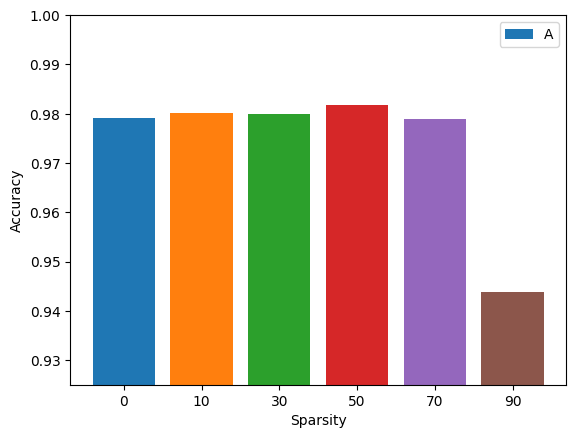

In [32]:
# INSERT YOUR CODE HERE
accuracy_results = []

for i in range(len(sparsity_values)):
    # model = model_names[i]
    sparsity = sparsity_values[i]

    accuracy = evaluate_accuracy(sparsity)
    accuracy_results.append(accuracy)

fig, ax = plt.subplots()

bar_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
bar_labels = ['0', '10', '30', '50', '70', '90']

ax.bar(bar_labels, accuracy_results, color=bar_colors, label=None)

ax.set_ylabel('Accuracy')
ax.set_xlabel('Sparsity')
ax.legend('Accuracy for different sparsity values')
ax.set_ylim([0.925, 1])

plt.show()

We can see that the only noticeable change in accuracy occurs at the 90% sparsity mark

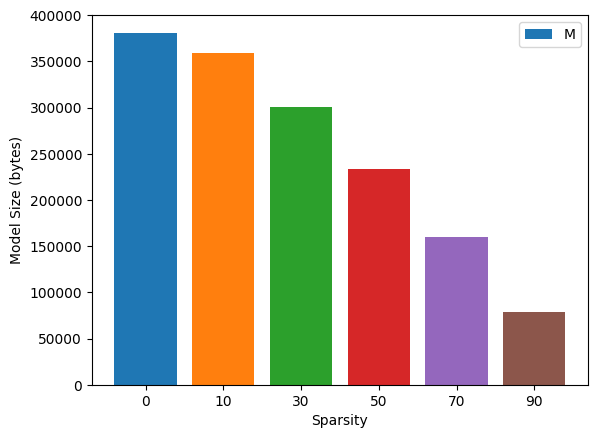

In [33]:
# INSERT YOUR CODE HERE
model_sizes = []

for i in range(len(sparsity_values)):
    sparsity = sparsity_values[i]

    model_size = evaluate_mode_size(sparsity)
    model_sizes.append(model_size)

fig, ax = plt.subplots()

bar_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
bar_labels = ['0', '10', '30', '50', '70', '90']

ax.bar(bar_labels, model_sizes, color=bar_colors, label=None)

ax.set_ylabel('Model Size (bytes)')
ax.set_xlabel('Sparsity')
ax.legend('Model size for different sparsity values')
ax.set_ylim([0, 400000])

plt.show()
    

From the bar graph, we can see that the size of the model only starts to go down noticeably at a sparsity of 50%

313/313 [==============================] - 0s 936us/step


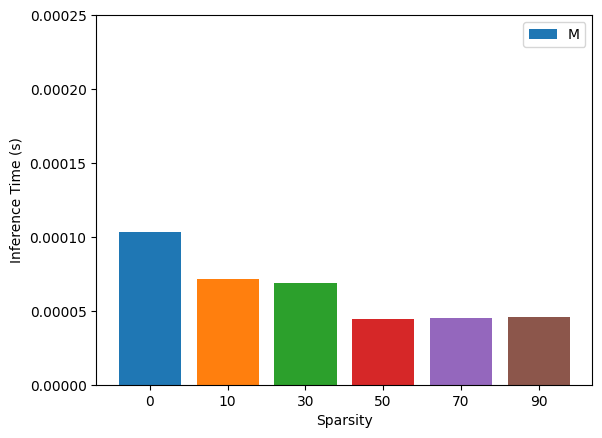

In [34]:
# INSERT YOUR CODE HERE
inference_time_results = []

for i in range(len(sparsity_values)):
    sparsity = sparsity_values[i]

    inference_time = evaluate_inference_time(sparsity)
    inference_time_results.append(inference_time)

fig, ax = plt.subplots()

bar_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']
bar_labels = ['0', '10', '30', '50', '70', '90']

ax.bar(bar_labels, inference_time_results, color=bar_colors, label=None)

ax.set_ylabel('Inference Time (s)')
ax.set_xlabel('Sparsity')
ax.legend('Model size for different sparsity values')
ax.set_ylim([0, 0.00025])

plt.show()

We can see that using sparsity of 30% yields the smallest inference time value, and using 70% yields the highest.

# **Part 2**:  Quantization
This part of the lab demonstrates applying quantization to a neural network to reduce size and inference while maintaining a similar accuracy to the original neural network. At a high level, the steps required to quantize and evaluate a model are as follows:

- Build and train the dense baseline
- Apply quantization during conversion to TFLite
- Evaluate the model

There are different quantization techniques, the technique demonstrated in this lab is post-training quantization. The main idea behind quantization is that the weights and activations can be converted to types with reduced precision, such as 16 bit floats or 8 bit integers instead of 32 bit floats which can signficantly reduce model size and inference with minimal accuracy tradeoffs.

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

A TensorFlow Lite model is represented in a special efficient portable format known as FlatBuffers (identified by the .tflite file extension). This provides several advantages over TensorFlow's protocol buffer model format such as reduced size (small code footprint) and faster inference (data is directly accessed without an extra parsing/unpacking step) that enables TensorFlow Lite to execute efficiently on devices with limited compute and memory resources.
You can find more information here: https://www.tensorflow.org/lite/guide

### Load base model
Firstly, let us load the base model we have trained earlier.

In [35]:
model_to_quantize = tf.keras.models.load_model('trained_base_model.h5')
model_to_quantize.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101770 (397.54 KB)
Trainable params: 101770 (397.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Convert to TFLite and apply quantization
The next step is converting the base model to a TFLite model and applying quantization through the different APIs that TFLite provides. In this example we are using 8-bit quantization, this is done by using the DEFAULT optimizer. The commented codes provide an example of how to apply 16-bit floating point quantization.

In [36]:
# Passing the Keras model to the TFLite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
# Setting the deault optimizer
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# To convert to 16-bit floating point for example
# converter.target_spec.supported_types = [tf.float16]
# Convert the model
quantized_tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmplezbq1c7/assets


INFO:tensorflow:Assets written to: /tmp/tmplezbq1c7/assets
2024-02-03 06:09:51.830210: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-03 06:09:51.830252: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-03 06:09:51.830515: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmplezbq1c7
2024-02-03 06:09:51.831082: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-03 06:09:51.831098: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmplezbq1c7
2024-02-03 06:09:51.832148: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2024-02-03 06:09:51.832679: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-03 06:09:51.855852: I tensorflow/cc/saved_model/loader.cc:217] Running initializatio

### Save TFLite model and load model into an interpeter
Firstly we save the TFLite model, this will allow us to load it into an interpreter. To perform an inference with a TensorFlow Lite model, you must run it through an interpreter. The TensorFlow Lite interpreter is designed to be lean and fast.
You can find more information on the TFLite interpeter here: https://www.tensorflow.org/lite/guide/inference

In [37]:
# Save TFLite Model
with open('quantized_tflite_model.tflite', 'wb') as f:
  f.write(quantized_tflite_model)
# Load model into interpeter
interpreter_quant = tf.lite.Interpreter(model_path=str('quantized_tflite_model.tflite'))
interpreter_quant.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


### Evaluate the model
Finally, we evaluate the quantized model in terms of accuracy, inference time and model size.

In [38]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter, model_path):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    startTime = time.time()
    interpreter.invoke()
    executionTime = (time.time() - startTime)/len(test_images)

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  model_size = get_gzipped_model_size(model_path)
  # Print
  print('\nModel Accuracy:', accuracy*100, '%')
  print("Model Size: %.2f bytes" % (model_size))
  print("Inference Time is", executionTime, "s")
  return accuracy, model_size, executionTime

evaluate_model(interpreter_quant, 'quantized_tflite_model.tflite')


Model Accuracy: 97.78 %
Model Size: 81981.00 bytes
Inference Time is 6.437301635742188e-10 s


(0.9778, 81981, 6.437301635742188e-10)

### Exercise (0.5 points)

Question 1: Load the base model and apply 16 bit floating point quantization. Use the TFLite interpeter to evaluate your model. **(0.5 points)**

In [39]:
# INSERT YOUR CODE HERE
model_to_quantize = tf.keras.models.load_model('trained_base_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
fp16_quantized_tflite_model = converter.convert()

with open('fp16_quantized_tflite_model.tflite', 'wb') as f:
  f.write(fp16_quantized_tflite_model)
interpreter_fp16_quant = tf.lite.Interpreter(model_path=str('fp16_quantized_tflite_model.tflite'))
interpreter_fp16_quant.allocate_tensors()

evaluate_model(interpreter_fp16_quant, 'fp16_quantized_tflite_model.tflite')

INFO:tensorflow:Assets written to: /tmp/tmpfg_h96xp/assets


INFO:tensorflow:Assets written to: /tmp/tmpfg_h96xp/assets
2024-02-03 06:09:52.727238: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-03 06:09:52.727296: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-03 06:09:52.727551: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpfg_h96xp
2024-02-03 06:09:52.728212: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-03 06:09:52.728232: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpfg_h96xp
2024-02-03 06:09:52.729715: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-03 06:09:52.756173: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpfg_h96xp
2024-02-03 06:09:52.763113: I tensorflow/cc/saved_model/loader.cc:316] SavedModel


Model Accuracy: 97.78999999999999 %
Model Size: 189946.00 bytes
Inference Time is 1.2874603271484376e-09 s


(0.9779, 189946, 1.2874603271484376e-09)

# Part 3: Collaborative Optimization



### Exercise
Question 1 (2 points): Using the knowledge from part 1 and part 2, jointly apply pruning and post-training quantization to the base MNIST model.

Try the following combinations and plot 3 graphs (one for each metric of accuracy, model size , and inference time):

- no pruning, no quantization
- no pruning, fp16 quantization
- no pruning, 8-bit quantization

- 10% sparsity, no quantization
- 10% sparsity, fp16 quantization
- 10% sparsity, 8-bit quantization

- 50% sparsity, no quantization
- 50% sparsity, fp16 quantization
- 50% sparsity, 8-bit quantization

- 90% sparsity, no quantization
- 90% sparsity, fp16 quantization
- 90% sparsity, 8-bit quantization

To do this, write a prune_and_quantize function and loop over different sparsities and then append all the results into 3 different arrays (one for each metric).

For example the function definition could look like this:

**def prune_and_quantize(model, target_sparsity, fp16: bool, path_to_save)**

Hint: Below is an example of how you can graph your results using matplotlib
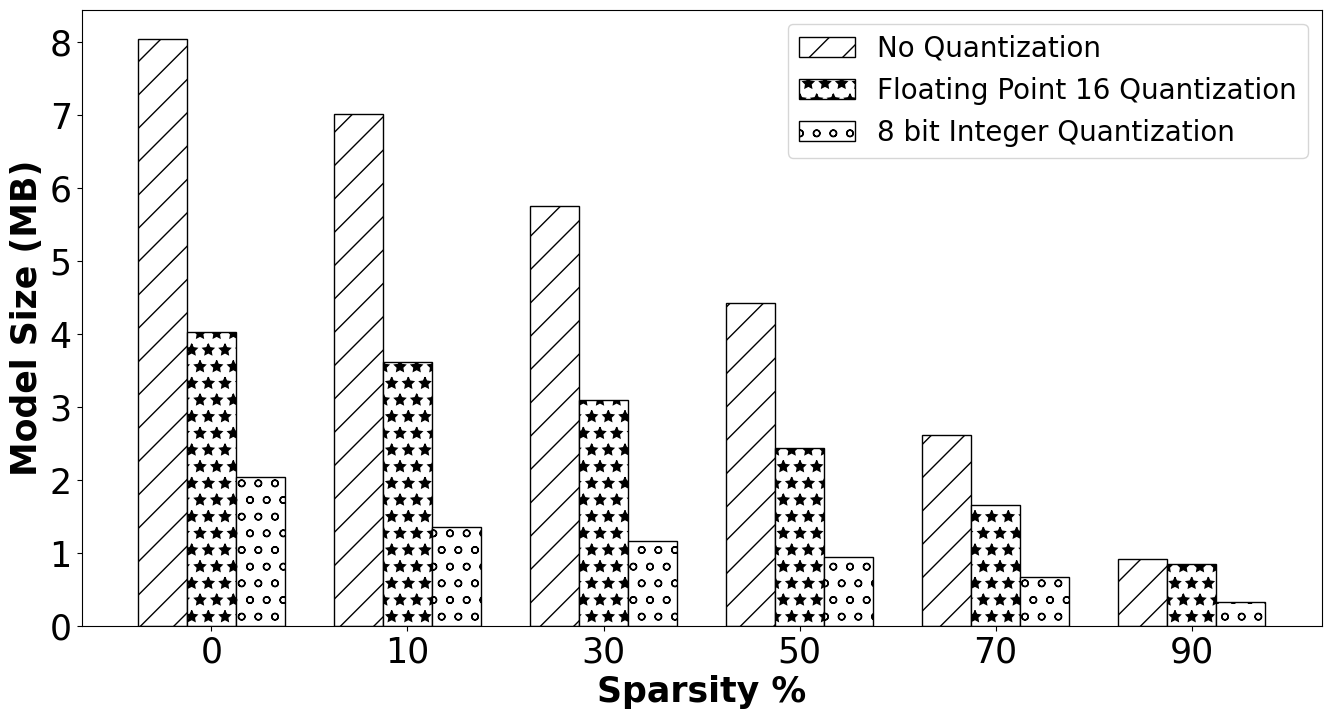

In [40]:
def prune_and_quantize(model, tagret_sparsity, fp16: bool, path_to_save):
    # Prune model with target sparsity
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

    # Define model for pruning. The sparsity is the target sparsity
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(tagret_sparsity, begin_step=0, frequency=100)
    }

    pruned_model = prune_low_magnitude(model, **pruning_params)

    # `prune_low_magnitude` requires a recompile.
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    pruned_model.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    pruned_model.summary()

    # Fine tune the pruned model
    callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep(),
    ]

    pruned_model.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                      callbacks=callbacks)

    # Strip the pruned model
    stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)

    # Convert to TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(stripped_pruned_model)
    if fp16:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        converter.target_spec.supported_types = [tf.float16]
    else:
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
    quantized_tflite_model = converter.convert()

    with open(path_to_save, 'wb') as f:
        f.write(quantized_tflite_model)
    interpreter_quant = tf.lite.Interpreter(model_path=str(path_to_save))
    interpreter_quant.allocate_tensors()

    return stripped_pruned_model

In [41]:
sparsity_values = [0, 0.1, 0.5, 0.9]
model = tf.keras.models.load_model('trained_base_model.h5')

for i in range(len(sparsity_values)):
    sparsity = sparsity_values[i]
    fp16 = False
    prune_and_quantize(model, sparsity, fp16, 'pruned_tflite_model_sparsity_' + str(sparsity) + '_8_bit_quantization.tflite')
    fp16 = True
    prune_and_quantize(model, sparsity, fp16, 'pruned_tflite_model_sparsity_' + str(sparsity) + '_fp16_quantization.tflite')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

INFO:tensorflow:Assets written to: /tmp/tmpx2etuf31/assets
2024-02-03 06:10:02.974613: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-03 06:10:02.974657: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-03 06:10:02.974825: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpx2etuf31
2024-02-03 06:10:02.975314: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-03 06:10:02.975331: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpx2etuf31
2024-02-03 06:10:02.976351: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-03 06:10:02.987080: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpx2etuf31
2024-02-03 06:10:02.991350: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

INFO:tensorflow:Assets written to: /tmp/tmp3gt_1lpo/assets
2024-02-03 06:10:13.003425: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-03 06:10:13.003466: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-03 06:10:13.003632: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3gt_1lpo
2024-02-03 06:10:13.004106: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-03 06:10:13.004125: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp3gt_1lpo
2024-02-03 06:10:13.005140: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-03 06:10:13.015300: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp3gt_1lpo
2024-02-03 06:10:13.019582: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

INFO:tensorflow:Assets written to: /tmp/tmp3dmxpphc/assets
2024-02-03 06:10:24.805550: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-03 06:10:24.805590: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-03 06:10:24.805758: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp3dmxpphc
2024-02-03 06:10:24.806211: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-03 06:10:24.806228: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp3dmxpphc
2024-02-03 06:10:24.807247: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-03 06:10:24.817670: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp3dmxpphc
2024-02-03 06:10:24.821933: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

INFO:tensorflow:Assets written to: /tmp/tmpp4xoqehs/assets
2024-02-03 06:10:35.179400: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-03 06:10:35.179442: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-03 06:10:35.179615: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpp4xoqehs
2024-02-03 06:10:35.180097: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-03 06:10:35.180116: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpp4xoqehs
2024-02-03 06:10:35.181134: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-03 06:10:35.191245: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpp4xoqehs
2024-02-03 06:10:35.195497: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

INFO:tensorflow:Assets written to: /tmp/tmpm8m3sa3c/assets
2024-02-03 06:10:46.033254: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

2024-02-03 06:10:46.033302: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-03 06:10:46.033559: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpm8m3sa3c
2024-02-03 06:10:46.034384: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-03 06:10:46.034406: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpm8m3sa3c
2024-02-03 06:10:46.039129: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-03 06:10:46.055712: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpm8m3sa3c
2024-02-03 06:10:46.062902: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 29345 microseconds.
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 *

Epoch 1/2
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0292 - accuracy: 0.9896 - val_loss: 0.0730 - val_accuracy: 0.9813
Epoch 2/2
1688/1688 [==============================] - 4s 3ms/step - loss: 0.0274 - accuracy: 0.9911 - val_loss: 0.0693 - val_accuracy: 0.9847
INFO:tensorflow:Assets written to: /tmp/tmpy0mzgj2m/assets


INFO:tensorflow:Assets written to: /tmp/tmpy0mzgj2m/assets
2024-02-03 06:10:56.515535: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-03 06:10:56.515577: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-03 06:10:56.515765: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpy0mzgj2m
2024-02-03 06:10:56.516224: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-03 06:10:56.516241: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpy0mzgj2m
2024-02-03 06:10:56.517255: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-03 06:10:56.528245: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpy0mzgj2m
2024-02-03 06:10:56.534352: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

INFO:tensorflow:Assets written to: /tmp/tmp_td3ghne/assets
2024-02-03 06:11:06.858448: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-03 06:11:06.858490: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-03 06:11:06.858657: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp_td3ghne
2024-02-03 06:11:06.859092: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-03 06:11:06.859110: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp_td3ghne
2024-02-03 06:11:06.860145: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-03 06:11:06.870469: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp_td3ghne
2024-02-03 06:11:06.874845: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatte  (None, 784)               1         
 n (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense   (None, 128)               200834    
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_dropou  (None, 128)               1         
 t (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dense_  (None, 10)                2572      
 1 (PruneLowMagnitude)                                           
                                                                 
Total params: 203408 (794.58 KB)
Trainable params: 10177

INFO:tensorflow:Assets written to: /tmp/tmp58wdcbqy/assets
2024-02-03 06:11:18.740002: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-03 06:11:18.740041: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-03 06:11:18.740212: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp58wdcbqy
2024-02-03 06:11:18.740651: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-03 06:11:18.740667: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp58wdcbqy
2024-02-03 06:11:18.741648: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-03 06:11:18.751794: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp58wdcbqy
2024-02-03 06:11:18.756007: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

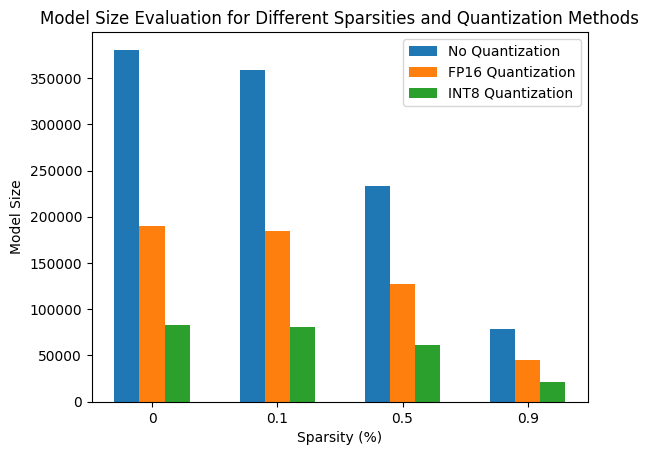

In [42]:
def evaluate_model_size(sparsity, quantization):
    # Evaluate Model Size
    if quantization == 'no_quantization':
        model_name = 'stripped_pruned_model_q3_sparsity_' + str(sparsity) + '.h5'
        model_size = get_gzipped_model_size(model_name)
    if quantization == 'fp16_quantization':
        model_name = 'pruned_tflite_model_sparsity_' + str(sparsity) + '_fp16_quantization.tflite'
        model_size = get_gzipped_model_size(model_name)
    if quantization == 'int8_quantization':
        model_name = 'pruned_tflite_model_sparsity_' + str(sparsity) + '_8_bit_quantization.tflite'
        model_size = get_gzipped_model_size(model_name)

    return model_size

sparsities = [0, 0.1, 0.5, 0.9]
quantization_methods = ['no_quantization', 'fp16_quantization', 'int8_quantization']

# Create lists to store results for plotting
model_sizes = []

# Evaluate model size for each combination of sparsity and quantization
for sparsity in sparsities:
    for quantization in quantization_methods:
        size = evaluate_model_size(sparsity, quantization)
        model_sizes.append((sparsity, quantization, size))

# Separate results for each quantization method
no_quantization_sizes = [size for sparsity, quantization, size in model_sizes if quantization == 'no_quantization']
fp16_quantization_sizes = [size for sparsity, quantization, size in model_sizes if quantization == 'fp16_quantization']
int8_quantization_sizes = [size for sparsity, quantization, size in model_sizes if quantization == 'int8_quantization']

# Plotting the bar graph
bar_width = 0.2  # You can adjust this value based on your preference
bar_positions = range(len(sparsities))

plt.bar([pos - bar_width for pos in bar_positions], no_quantization_sizes, width=bar_width, label='No Quantization')
plt.bar(bar_positions, fp16_quantization_sizes, width=bar_width, label='FP16 Quantization')
plt.bar([pos + bar_width for pos in bar_positions], int8_quantization_sizes, width=bar_width, label='INT8 Quantization')

plt.xlabel('Sparsity (%)')
plt.ylabel('Model Size')
plt.title('Model Size Evaluation for Different Sparsities and Quantization Methods')
plt.xticks(bar_positions, sparsities)
plt.legend()
plt.show()

Question-2 (1 point) Redo question 1 above (using the funnction that you wrote) but this time using the CNN model that you proposed in Lab-1 Q4 as the base model. Discuss the trade-offs obtained between accuracy and model size as a function of pruning level and quantization. This time, also plot the histrogram of weights (a particular layer or all over them combined) for at least 2 different pruning levels (sample code for this is shown under visualize pruning. Does the histogram of pruned weights give any insights on the accuracy observed?

In [43]:
base_model_part3 = tf.keras.models.load_model('part2_model_q4.h5')

def create_pruned_model_part3 (sparsity) :
    # Prune model with target sparsity
    prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

    # Define model for pruning. The sparsity is the target sparsity
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(sparsity, begin_step=0, frequency=100)
    }

    pruned_model_q2 = prune_low_magnitude(base_model_part3, **pruning_params)

    # `prune_low_magnitude` requires a recompile.
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    pruned_model_q2.compile(optimizer='adam',
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    pruned_model_q2.summary()

    # Fine tune the pruned model
    callbacks = [
      tfmot.sparsity.keras.UpdatePruningStep(),
    ]

    pruned_model_q2.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                      callbacks=callbacks)

    # Strip the pruned model
    stripped_pruned_model_q2 = tfmot.sparsity.keras.strip_pruning(pruned_model_q2)
    model_name = 'stripped_pruned_model_q2_sparsity_' + str(sparsity) + '.h5'
    stripped_pruned_model_q2.save(model_name)

    # Confirm pruning was applied correctly
    print_model_weights_sparsity(stripped_pruned_model_q2)

    return pruned_model_q2

In [44]:
sparsity_values = [0, 0.1, 0.5, 0.9]

for i in range(len(sparsity_values)):
    sparsity = sparsity_values[i]
    create_pruned_model_part3(sparsity)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 14, 14, 6)         116       
 _70 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 7, 7, 6)           1         
 e_pooling2d_49 (PruneLowMa                                      
 gnitude)                                                        
                                                                 
 prune_low_magnitude_conv2d  (None, 2, 2, 8)           1546      
 _71 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 1, 1, 8)           1         
 e_pooling2d_50 (PruneLowMa                                      
 gnitude)                                            

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 8s 3ms/step - loss: 0.8649 - accuracy: 0.7051 - val_loss: 0.4089 - val_accuracy: 0.8745
Epoch 2/2
1688/1688 [==============================] - 5s 3ms/step - loss: 0.3767 - accuracy: 0.8816 - val_loss: 0.2623 - val_accuracy: 0.9235


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


conv2d_70/kernel:0: 0.00% sparsity  (0/54)
conv2d_71/kernel:0: 0.00% sparsity  (0/768)
dense_84/kernel:0: 0.00% sparsity  (0/960)
dense_85/kernel:0: 0.00% sparsity  (0/10080)
dense_86/kernel:0: 0.00% sparsity  (0/840)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 14, 14, 6)         116       
 _70 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 7, 7, 6)           1         
 e_pooling2d_49 (PruneLowMa                                      
 gnitude)                                                        
                                                                 
 prune_low_magnitude_conv2d  (None, 2, 2, 8)           1546      
 _71 (PruneLowMagnitude)                                         
                                 

conv2d_70/kernel:0: 9.26% sparsity  (5/54)
conv2d_71/kernel:0: 10.03% sparsity  (77/768)
dense_84/kernel:0: 10.00% sparsity  (96/960)
dense_85/kernel:0: 10.00% sparsity  (1008/10080)
dense_86/kernel:0: 10.00% sparsity  (84/840)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 14, 14, 6)         116       
 _70 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 7, 7, 6)           1         
 e_pooling2d_49 (PruneLowMa                                      
 gnitude)                                                        
                                                                 
 prune_low_magnitude_conv2d  (None, 2, 2, 8)           1546      
 _71 (PruneLowMagnitude)                                         
                       

conv2d_70/kernel:0: 50.00% sparsity  (27/54)
conv2d_71/kernel:0: 50.00% sparsity  (384/768)
dense_84/kernel:0: 50.00% sparsity  (480/960)
dense_85/kernel:0: 50.00% sparsity  (5040/10080)
dense_86/kernel:0: 50.00% sparsity  (420/840)
Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 14, 14, 6)         116       
 _70 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 7, 7, 6)           1         
 e_pooling2d_49 (PruneLowMa                                      
 gnitude)                                                        
                                                                 
 prune_low_magnitude_conv2d  (None, 2, 2, 8)           1546      
 _71 (PruneLowMagnitude)                                         
                  

conv2d_70/kernel:0: 90.74% sparsity  (49/54)
conv2d_71/kernel:0: 89.97% sparsity  (691/768)
dense_84/kernel:0: 90.00% sparsity  (864/960)
dense_85/kernel:0: 90.00% sparsity  (9072/10080)
dense_86/kernel:0: 90.00% sparsity  (756/840)


In [45]:
model = tf.keras.models.load_model('part2_model_q4.h5')
sparsity_values = [0, 0.1, 0.5, 0.9]

for i in range(len(sparsity_values)):
    sparsity = sparsity_values[i]
    fp16 = False
    prune_and_quantize(model, sparsity, fp16, 'pruned_tflite_model_sparsity_' + str(sparsity) + '_8_bit_quantization.tflite')
    fp16 = True
    prune_and_quantize(model, sparsity, fp16, 'pruned_tflite_model_sparsity_' + str(sparsity) + '_fp16_quantization.tflite')

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 14, 14, 6)         116       
 _70 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 7, 7, 6)           1         
 e_pooling2d_49 (PruneLowMa                                      
 gnitude)                                                        
                                                                 
 prune_low_magnitude_conv2d  (None, 2, 2, 8)           1546      
 _71 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 1, 1, 8)           1         
 e_pooling2d_50 (PruneLowMa                                      
 gnitude)                                            

INFO:tensorflow:Assets written to: /tmp/tmp4ig2w0q2/assets


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 14, 14, 6)         116       
 _70 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 7, 7, 6)           1         
 e_pooling2d_49 (PruneLowMa                                      
 gnitude)                                                        
                                                                 
 prune_low_magnitude_conv2d  (None, 2, 2, 8)           1546      
 _71 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 1, 1, 8)           1         
 e_pooling2d_50 (PruneLowMa                                      
 gnitude)                                            

2024-02-03 06:12:55.439954: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-03 06:12:55.439993: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-03 06:12:55.440162: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp4ig2w0q2
2024-02-03 06:12:55.440849: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-03 06:12:55.440866: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp4ig2w0q2
2024-02-03 06:12:55.442441: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-03 06:12:55.458909: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp4ig2w0q2
2024-02-03 06:12:55.465616: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 25455 m

Epoch 1/2


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 8s 3ms/step - loss: 0.2941 - accuracy: 0.9081 - val_loss: 0.2425 - val_accuracy: 0.9250
Epoch 2/2
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2534 - accuracy: 0.9211 - val_loss: 0.2261 - val_accuracy: 0.9327
INFO:tensorflow:Assets written to: /tmp/tmpvtoyrva3/assets


INFO:tensorflow:Assets written to: /tmp/tmpvtoyrva3/assets
2024-02-03 06:13:18.633507: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 14, 14, 6)         116       
 _70 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 7, 7, 6)           1         
 e_pooling2d_49 (PruneLowMa                                      
 gnitude)                                                        
                                                                 
 prune_low_magnitude_conv2d  (None, 2, 2, 8)           1546      
 _71 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 1, 1, 8)           1         
 e_pooling2d_50 (PruneLowMa                                      
 gnitude)                                            

2024-02-03 06:13:18.633546: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-03 06:13:18.633712: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpvtoyrva3
2024-02-03 06:13:18.634432: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-03 06:13:18.634449: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpvtoyrva3
2024-02-03 06:13:18.636168: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-03 06:13:18.652829: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpvtoyrva3
2024-02-03 06:13:18.659474: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 25763 microseconds.
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 *

Epoch 1/2


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 7s 3ms/step - loss: 0.2231 - accuracy: 0.9300 - val_loss: 0.1763 - val_accuracy: 0.9465
Epoch 2/2
1688/1688 [==============================] - 5s 3ms/step - loss: 0.2018 - accuracy: 0.9367 - val_loss: 0.1596 - val_accuracy: 0.9505
INFO:tensorflow:Assets written to: /tmp/tmp6ihkqx3_/assets


INFO:tensorflow:Assets written to: /tmp/tmp6ihkqx3_/assets


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 14, 14, 6)         116       
 _70 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 7, 7, 6)           1         
 e_pooling2d_49 (PruneLowMa                                      
 gnitude)                                                        
                                                                 
 prune_low_magnitude_conv2d  (None, 2, 2, 8)           1546      
 _71 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 1, 1, 8)           1         
 e_pooling2d_50 (PruneLowMa                                      
 gnitude)                                            

2024-02-03 06:13:42.029943: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-03 06:13:42.029986: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-03 06:13:42.030159: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6ihkqx3_
2024-02-03 06:13:42.030851: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-03 06:13:42.030868: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp6ihkqx3_
2024-02-03 06:13:42.032521: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-03 06:13:42.050315: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp6ihkqx3_
2024-02-03 06:13:42.057252: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 27094 m

Epoch 1/2


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 8s 3ms/step - loss: 0.1893 - accuracy: 0.9416 - val_loss: 0.1581 - val_accuracy: 0.9517
Epoch 2/2
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1782 - accuracy: 0.9438 - val_loss: 0.1364 - val_accuracy: 0.9578
INFO:tensorflow:Assets written to: /tmp/tmpsxrvavup/assets


INFO:tensorflow:Assets written to: /tmp/tmpsxrvavup/assets
2024-02-03 06:14:06.008858: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-03 06:14:06.008924: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-03 06:14:06.009162: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpsxrvavup
2024-02-03 06:14:06.010306: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-03 06:14:06.010327: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpsxrvavup
2024-02-03 06:14:06.012912: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-03 06:14:06.037394: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpsxrvavup
2024-02-03 06:14:06.048300: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 14, 14, 6)         116       
 _70 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 7, 7, 6)           1         
 e_pooling2d_49 (PruneLowMa                                      
 gnitude)                                                        
                                                                 
 prune_low_magnitude_conv2d  (None, 2, 2, 8)           1546      
 _71 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 1, 1, 8)           1         
 e_pooling2d_50 (PruneLowMa                                      
 gnitude)                                            

/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 8s 3ms/step - loss: 0.2031 - accuracy: 0.9361 - val_loss: 0.1654 - val_accuracy: 0.9495
Epoch 2/2
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1772 - accuracy: 0.9444 - val_loss: 0.1619 - val_accuracy: 0.9493
INFO:tensorflow:Assets written to: /tmp/tmpakcmch3g/assets


INFO:tensorflow:Assets written to: /tmp/tmpakcmch3g/assets
2024-02-03 06:14:29.400933: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 14, 14, 6)         116       
 _70 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 7, 7, 6)           1         
 e_pooling2d_49 (PruneLowMa                                      
 gnitude)                                                        
                                                                 
 prune_low_magnitude_conv2d  (None, 2, 2, 8)           1546      
 _71 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 1, 1, 8)           1         
 e_pooling2d_50 (PruneLowMa                                      
 gnitude)                                            

2024-02-03 06:14:29.400975: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-03 06:14:29.401147: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpakcmch3g
2024-02-03 06:14:29.402097: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-03 06:14:29.402119: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpakcmch3g
2024-02-03 06:14:29.403877: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-03 06:14:29.420513: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpakcmch3g
2024-02-03 06:14:29.427264: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 26118 microseconds.
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 *

Epoch 1/2


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 7s 3ms/step - loss: 0.1719 - accuracy: 0.9455 - val_loss: 0.1529 - val_accuracy: 0.9527
Epoch 2/2
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1657 - accuracy: 0.9479 - val_loss: 0.1427 - val_accuracy: 0.9570
INFO:tensorflow:Assets written to: /tmp/tmp6ys2sgk2/assets


INFO:tensorflow:Assets written to: /tmp/tmp6ys2sgk2/assets


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 14, 14, 6)         116       
 _70 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 7, 7, 6)           1         
 e_pooling2d_49 (PruneLowMa                                      
 gnitude)                                                        
                                                                 
 prune_low_magnitude_conv2d  (None, 2, 2, 8)           1546      
 _71 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 1, 1, 8)           1         
 e_pooling2d_50 (PruneLowMa                                      
 gnitude)                                            

2024-02-03 06:14:43.015376: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-03 06:14:43.015417: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-03 06:14:43.015588: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp6ys2sgk2
2024-02-03 06:14:43.016307: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-03 06:14:43.016327: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp6ys2sgk2
2024-02-03 06:14:43.017955: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-03 06:14:43.034746: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp6ys2sgk2
2024-02-03 06:14:43.041661: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 26074 m

Epoch 1/2


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 8s 3ms/step - loss: 2.0359 - accuracy: 0.2693 - val_loss: 1.9715 - val_accuracy: 0.2687
Epoch 2/2
1688/1688 [==============================] - 6s 4ms/step - loss: 1.9521 - accuracy: 0.2889 - val_loss: 1.8885 - val_accuracy: 0.3205
INFO:tensorflow:Assets written to: /tmp/tmp2ldnl952/assets


INFO:tensorflow:Assets written to: /tmp/tmp2ldnl952/assets
2024-02-03 06:15:06.423369: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.


Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_conv2d  (None, 14, 14, 6)         116       
 _70 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 7, 7, 6)           1         
 e_pooling2d_49 (PruneLowMa                                      
 gnitude)                                                        
                                                                 
 prune_low_magnitude_conv2d  (None, 2, 2, 8)           1546      
 _71 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_averag  (None, 1, 1, 8)           1         
 e_pooling2d_50 (PruneLowMa                                      
 gnitude)                                            

2024-02-03 06:15:06.423410: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-03 06:15:06.423577: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmp2ldnl952
2024-02-03 06:15:06.424294: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-03 06:15:06.424313: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmp2ldnl952
2024-02-03 06:15:06.425943: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-03 06:15:06.444135: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmp2ldnl952
2024-02-03 06:15:06.450762: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 27186 microseconds.
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 *

Epoch 1/2


/home/codespace/.python/current/lib/python3.10/site-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1688/1688 [==============================] - 7s 3ms/step - loss: 1.9053 - accuracy: 0.3144 - val_loss: 1.8564 - val_accuracy: 0.3467
Epoch 2/2
1688/1688 [==============================] - 6s 3ms/step - loss: 1.8837 - accuracy: 0.3268 - val_loss: 1.8398 - val_accuracy: 0.3408
INFO:tensorflow:Assets written to: /tmp/tmpytf45gb1/assets


INFO:tensorflow:Assets written to: /tmp/tmpytf45gb1/assets
2024-02-03 06:15:21.312967: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-02-03 06:15:21.313013: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-02-03 06:15:21.313195: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpytf45gb1
2024-02-03 06:15:21.313902: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-02-03 06:15:21.313919: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /tmp/tmpytf45gb1
2024-02-03 06:15:21.315673: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-02-03 06:15:21.333070: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: /tmp/tmpytf45gb1
2024-02-03 06:15:21.339960: I tensorflow/cc/saved_model/loader.cc:316] SavedModel

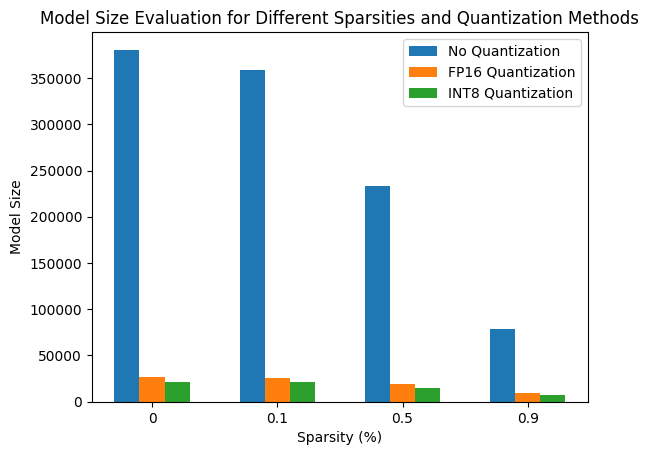

In [46]:
# Evaluate Model Size of proposed model
sparsities = [0, 0.1, 0.5, 0.9]
quantization_methods = ['no_quantization', 'fp16_quantization', 'int8_quantization']

# Create lists to store results for plotting
model_sizes = []

# Evaluate model size for each combination of sparsity and quantization
for sparsity in sparsities:
    for quantization in quantization_methods:
        size = evaluate_model_size(sparsity, quantization)
        model_sizes.append((sparsity, quantization, size))

# Separate results for each quantization method
no_quantization_sizes = [size for sparsity, quantization, size in model_sizes if quantization == 'no_quantization']
fp16_quantization_sizes = [size for sparsity, quantization, size in model_sizes if quantization == 'fp16_quantization']
int8_quantization_sizes = [size for sparsity, quantization, size in model_sizes if quantization == 'int8_quantization']

# Plotting the bar graph
bar_width = 0.2  # You can adjust this value based on your preference
bar_positions = range(len(sparsities))

plt.bar([pos - bar_width for pos in bar_positions], no_quantization_sizes, width=bar_width, label='No Quantization')
plt.bar(bar_positions, fp16_quantization_sizes, width=bar_width, label='FP16 Quantization')
plt.bar([pos + bar_width for pos in bar_positions], int8_quantization_sizes, width=bar_width, label='INT8 Quantization')

plt.xlabel('Sparsity (%)')
plt.ylabel('Model Size')
plt.title('Model Size Evaluation for Different Sparsities and Quantization Methods')
plt.xticks(bar_positions, sparsities)
plt.legend()
plt.show()

As we can see, quantization can dramtically decrease the size of the model, and pruning is also aimed at decreasing the size of the model. As with accuracy, pruning and quantization are both designed to only hinder the accuracy as minimal as possible.

# Optional: Visualize Pruning
In this section we will graph a small subset of the weights at different levels of pruning. The graphs clearly show how different sparsity levels affect the number of zero weights, it also shows that our pruning is unstructured.

We also provide histograms of the weights before and after pruning.

Note: Make sure you have saved the tflite files with the same names used below, alternatively you can change the model path with your correct file name. The first visualization relies on files collected from the exercise in PART 3!

In [ ]:
def get_tensor_data(model_path):
  # Load tflite file with the created pruned model
  interpreter = tf.lite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  details = interpreter.get_tensor_details()

  # Weights of the dense layer that has been pruned.
  tensor_name = 'sequential/dense_1/MatMul'
  detail = [x for x in details if tensor_name in x["name"]]

  # We need the first layer.
  tensor_data = interpreter.tensor(detail[0]["index"])()
  return tensor_data

# The value 10 is chosen for convenience.
width = height = 10


def plot_separation_lines(height, width):

    block_size = [1, 4]

    # Add separation lines to the figure.
    num_hlines = int((height - 1) / block_size[0])
    num_vlines = int((width - 1) / block_size[1])
    line_y_pos = [y * block_size[0] for y in range(1, num_hlines + 1)]
    line_x_pos = [x * block_size[1] for x in range(1, num_vlines + 1)]

    for y_pos in line_y_pos:
        plt.plot([-0.5, width], [y_pos - 0.5 , y_pos - 0.5], color='w')

    for x_pos in line_x_pos:
        plt.plot([x_pos - 0.5, x_pos - 0.5], [-0.5, height], color='w')

def plot_weights_graph(tensor_data, sparsity):
  weights_to_display = tf.reshape(tensor_data, [tensor_data.shape[0],tf.reduce_prod(tensor_data.shape[1:])])
  weights_to_display = weights_to_display[0:width, 0:height]

  val_ones = np.ones([height, width])
  val_zeros = np.zeros([height, width])
  subset_values_to_display = np.where(abs(weights_to_display) > 0, val_ones, val_zeros)

  plot_separation_lines(height, width)

  plt.axis('off')
  plt.imshow(subset_values_to_display)
  plt.colorbar()
  plt.title("Pruned weights for {0}% sparsity".format(sparsity))
  plt.show()

## USE YOUR MODEL PATH
plot_weights_graph(get_tensor_data('pruned_0.9_fp16_quantized_tflite_model.tflite'), 90)
plot_weights_graph(get_tensor_data('pruned_0.5_fp16_quantized_tflite_model.tflite'), 50)
plot_weights_graph(get_tensor_data('pruned_0.1_fp16_quantized_tflite_model.tflite'), 10)
plot_weights_graph(get_tensor_data('pruned_0_fp16_quantized_tflite_model.tflite'), 0)

ValueError: Could not open 'pruned_0.9_fp16_quantized_tflite_model.tflite'.

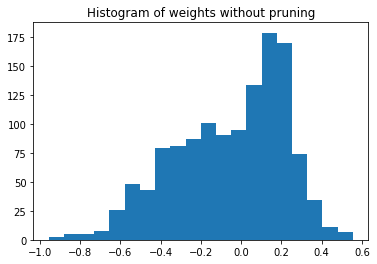

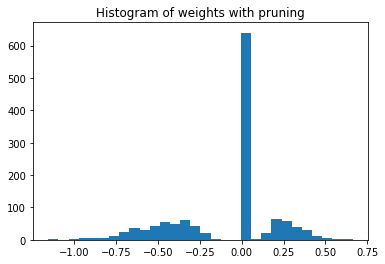

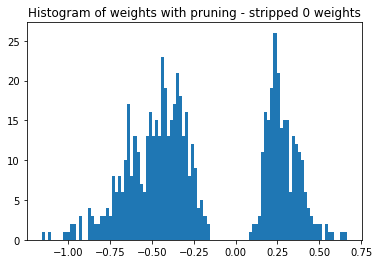

In [ ]:
## Plotting Pruning Histograms
model = tf.keras.models.load_model('trained_base_model.h5')
a = model.layers[3].weights
b = pruned_model.layers[3].weights

k = a[0].numpy().flatten()
plt.hist(k, bins = 100)
plt.title("Histogram of weights without pruning")
plt.show()

j = b[0].numpy().flatten()
plt.hist(j, bins = 100)
plt.title("Histogram of weights with pruning")
plt.show()

l = j[j != 0]
plt.hist(l, bins = 100)
plt.title("Histogram of weights with pruning - stripped 0 weights")
plt.show()